In [255]:
#Dependencies
from dotenv import load_dotenv

#Langchain Components
from langchain_core.documents import Document
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, BaseMessage
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser,PydanticOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings

#Graph and State managemnt
from langgraph.graph import START,END, StateGraph
from typing import TypedDict, Literal,List,Annotated
from pydantic import BaseModel, Field
from langgraph.checkpoint.memory import MemorySaver


In [256]:
load_dotenv()

True

### 2. Building Our Knowledge Base

In [257]:
#Initialize embedding model
embedding = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')

# Create comprehensive technology support knowledge base
knowledge_documents = [
    Document(
        page_content="TechFlow Solutions offers three main service tiers: Basic Support ($29/month) includes email support and basic troubleshooting, Professional Support ($79/month) includes priority phone support and advanced diagnostics, Enterprise Support ($199/month) includes 24/7 dedicated support and custom integrations.",
        metadata={"source": "pricing_guide.pdf", "category": "pricing"},
    ),
    Document(
        page_content="Our cloud infrastructure services include: Virtual Private Servers starting at $15/month, Managed Databases from $45/month, Content Delivery Network at $0.08/GB, and Load Balancing services at $25/month. All services include 99.9% uptime guarantee.",
        metadata={"source": "infrastructure_pricing.pdf", "category": "services"},
    ),
    Document(
        page_content="TechFlow Solutions was founded in 2018 by Maria Rodriguez, a former Google engineer with 15 years of experience in cloud architecture. The company has grown from 3 employees to over 150 team members across 12 countries, specializing in enterprise cloud solutions.",
        metadata={"source": "company_history.pdf", "category": "company"},
    ),
    Document(
        page_content="Our technical support team operates 24/7 for Enterprise customers, business hours (9 AM - 6 PM EST) for Professional customers, and email-only support for Basic customers. Average response times: Enterprise (15 minutes), Professional (2 hours), Basic (24 hours).",
        metadata={"source": "support_procedures.pdf", "category": "support"},
    )
]


#Create Vector Store and Retriever

vector_store= Chroma.from_documents(documents=knowledge_documents, embedding=embedding)
retriever= vector_store.as_retriever(search_type='similarity',search_kwargs={"k": 2})

In [258]:
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite", temperature=0.1)

In [259]:
#State
class ConversationState(TypedDict):
    conversation_history: List[BaseMessage]  # Full conversation thread
    retrieved_documents: List[Document]      # Current retrieved documents
    topic_relevance: str                     # On-topic or off-topic classification
    enhanced_query: str                      # Reformulated question
    should_generate: bool                    # Whether to proceed with answer generation
    optimization_attempts: int              # Number of query refinement attempts
    current_query: HumanMessage             # User's current question

In [260]:
def enhance_query(state: ConversationState):
    """
    Reformulates user questions based on conversation history to create 
    standalone queries optimized for vector search.
    """
    print(f"Enhancing query: {state['current_query'].content}")
    
    # Initialize state for new query processing
    state["retrieved_documents"] = []
    state["topic_relevance"] = ""
    state["enhanced_query"] = ""
    state["should_generate"] = False
    state["optimization_attempts"] = 0
    
    # Ensure conversation history exists
    if "conversation_history" not in state or state["conversation_history"] is None:
        state["conversation_history"] = []
    
    # Add current query to history if not already present
    if state["current_query"] not in state["conversation_history"]:
        state["conversation_history"].append(state["current_query"])
    
    # Check if we have conversation context
    if len(state["conversation_history"]) > 1:
        # Extract context and current question
        previous_messages = state["conversation_history"][:-1]
        current_question = state["current_query"].content
        
        # Build context-aware prompt
        context_messages = [
            SystemMessage(
                content="""You are an expert query reformulator. Transform the user's question into a standalone, 
                search-optimized query that incorporates relevant context from the conversation history.
                
                Guidelines:
                - Make the question self-contained and clear
                - Preserve the user's intent while adding necessary context
                - Optimize for vector database retrieval
                - Keep the reformulated query concise but comprehensive"""
            )
        ]
        context_messages.extend(previous_messages)
        context_messages.append(HumanMessage(content=f"Current question: {current_question}"))
        
        # Generate enhanced query
        enhancement_prompt = ChatPromptTemplate.from_messages(context_messages)
        llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0.1)
        
        formatted_prompt = enhancement_prompt.format()
        response = llm.invoke(formatted_prompt)
        enhanced_question = response.content.strip()
        
        print(f"Enhanced query: {enhanced_question}")
        state["enhanced_query"] = enhanced_question
    else:
        # First question in conversation - use as-is
        state["enhanced_query"] = state["current_query"].content
        print(f"First query - using original: {state['enhanced_query']}")
    
    return state

In [261]:
# #Query Enhancing
# def enhance_query(state: ConversationState)-> ConversationState:
#     print(f"Enhancing query: {state['current_query'].content}")
#     current_query= state['current_query'].content
    
#     if state['conversation_history'] is None or 'conversation_history'  not in state:
#         state['conversation_history']=[]
#     if current_query not in state['conversation_history']:
#         state['conversation_history'].append(current_query)
#     if len(state['conversation_history'])>1:
#         previous_messages= state['conversation_history'][:-1]
#         context_messages= [SystemMessage(content="""You are an expert query reformulator. Transform the user's question into a standalone, 
#                 search-optimized query that incorporates relevant context from the conversation history.
                
#                 Guidelines:
#                 - Make the question self-contained and clear
#                 - Preserve the user's intent while adding necessary context
#                 - Optimize for vector database retrieval
#                 - Keep the reformulated query concise but comprehensive""")]
#         context_messages.extend(previous_messages)
#         context_messages.append(HumanMessage(content=f"Current question: {current_query}"))
#         prompt= ChatPromptTemplate.invoke(context_messages)
#         formatted_prompt= prompt.format()

#         response= llm.invoke(formatted_prompt).content
#         state['enhanced_query']= response
#     else:
#         state['enhanced_query']=state['current_query']
#     return state

    


In [262]:
# Classify Domain
class Domain_classification(BaseModel):
    classification: Annotated[Literal['Relevant','Irrelevant'],Field(description="Is the question about TechFlow Solutions services/pricing/company? Answer 'RELEVANT' or 'IRRELEVANT'")]
    confidence: Annotated[Literal['High','Medium','Low'],Field(description="Provide the answer with Confidence level: 'HIGH', 'MEDIUM', or 'LOW'")]

def validate_topic(state:ConversationState)->ConversationState:
    print("Validating topic relevance...")
    structured_llm= llm.with_structured_output(Domain_classification)
    enhanced_query= state['enhanced_query']
    prompt= ChatPromptTemplate([
        SystemMessage(content="""You are a topic classifier for TechFlow Solutions support system.
        
        RELEVANT topics include:
        - TechFlow Solutions services (cloud infrastructure, migration, DevOps)
        - Pricing for any TechFlow Solutions products or services
        - Company information (history, team, locations)
        - Support procedures and response times
        - Security and compliance features
        - Technical specifications and capabilities
        
        IRRELEVANT topics include:
        - General technology questions not specific to TechFlow
        - Other companies' products or services
        - Personal questions unrelated to business
        - Weather, news, or general knowledge queries
        
        Classify based on the enhanced query which incorporates conversation context."""),
        HumanMessage(content=f'{enhanced_query}')])
    
    chain= prompt | structured_llm
    response= chain.invoke({'enhanced_query':enhanced_query})
    state['topic_relevance']=response.classification
    print(f"Topic classification: {state['topic_relevance']} (Confidence: {response.confidence})")

    return state

  

In [263]:
# structured_llm= llm.with_structured_output(Domain_classification)
# enhanced_query= "What is My name"
# prompt= ChatPromptTemplate([
#     SystemMessage(content="""You are a topic classifier for TechFlow Solutions support system.
    
#     RELEVANT topics include:
#     - TechFlow Solutions services (cloud infrastructure, migration, DevOps)
#     - Pricing for any TechFlow Solutions products or services
#     - Company information (history, team, locations)
#     - Support procedures and response times
#     - Security and compliance features
#     - Technical specifications and capabilities
    
#     IRRELEVANT topics include:
#     - General technology questions not specific to TechFlow
#     - Other companies' products or services
#     - Personal questions unrelated to business
#     - Weather, news, or general knowledge queries
    
#     Classify based on the enhanced query which incorporates conversation context."""),
#     HumanMessage(content=enhanced_query)])

# chain= prompt | structured_llm
# response= chain.invoke({})
# topic_relevance=response.classification
# print(f"Topic classification: {topic_relevance} and with Confidence: {response.confidence})")


In [280]:
# Retrieve documents 
def fetch_content(state: ConversationState)->ConversationState:
    """
    Retrieves documents from the knowledge base using the enhanced query.
    """
    print("Fetching relevant documents...")
    
    enhanced_query= state['enhanced_query']
    retrieved_docs= retriever.invoke(enhanced_query)
    for i, j in enumerate(retrieved_docs):
        print(f'Document{i+1}:{j.page_content[:50]}')
    state['retrieved_documents']= retrieved_docs
    return state
    

In [265]:
# enhanced_query= "Tell me about TechFlow Solutions"
# retrieved_docs= retriever.invoke(enhanced_query)
# print(retrieved_docs)


In [266]:
# for i in range(len(retrieved_docs)):
#     print(retrieved_docs[i].page_content)

In [267]:


def handoff_topic(state: ConversationState)->ConversationState:
    """Handles queries outside our knowledge domain"""
    print("Handling off-topic query...")
    
    if "conversation_history" not in state or state["conversation_history"] is None:
        state["conversation_history"] = []
    
    off_topic_response = """I'm specialized in helping with TechFlow Solutions services, pricing, and company information. 
    Your question seems to be outside my area of expertise. 
    
    I can help you with:
    - Our cloud infrastructure services and pricing
    - Support procedures and response times  
    - Company information and team details
    - Security and compliance features
    
    Is there something specific about TechFlow Solutions I can help you with?"""
    
    state["conversation_history"].append(AIMessage(content=off_topic_response))


In [268]:
#Defining pydantic model for relevancy
class classify_documents(BaseModel):
    relevance: Annotated[Literal['Relevant_Document','NotRelevant_Document'],Field(description="""Is this document relevant to answering the question? Answer 'RELEVANT' or 'IRRELEVANT'""")]
    reasoning: Annotated[str, Field(description="Brief explanation of why the document is relevant or irrelevant")]

classify_documents_llm= llm.with_structured_output(classify_documents)

#Checking relevancy of user question with fetched documents
def access_relevance(state: ConversationState)->ConversationState:
    print("Assessing document relevance...")
    retrieved_docs= state['retrieved_documents']
    enhanced_query= state['enhanced_query']

    prompt = ChatPromptTemplate([
    ("system", """You are a document relevance assessor. Evaluate whether each document 
        contains information that can help answer the user's question.
        
        A document is RELEVANT if it contains:
        - Direct answers to the question
        - Supporting information that contributes to a complete answer
        - Context that helps understand the topic
        
        A document is IRRELEVANT if it:
        - Contains no information related to the question
        - Discusses completely different topics
        - Provides no value for answering the question
        
        Be strict but fair in your assessment."""),
    ("human", """Question: {question}
    
    Document to assess:
    {doc_content}
    
    Is this document relevant for answering the question?""")
    ])

    chain = prompt | classify_documents_llm

    filtered_docs = []

    # 2. Loop and invoke the chain
    for doc in retrieved_docs:
        response = chain.invoke({
            "question": enhanced_query, 
            "doc_content": doc.page_content
        })
        print(f"Document {i+1}: {response.relevance} - {response.reasoning}")

        if response.relevance=='Relevant_Document':
            filtered_docs.append(doc) 

    state['retrieved_documents']= filtered_docs
    
    if len(state['retrieved_documents'])>0:
        state['should_generate']= True

    return state


In [269]:
def generate_response(state: ConversationState)->ConversationState:

    print("Generating contextual response...")
    conversation_history= state['conversation_history']
    enhanced_query= state['enhanced_query']
    relevant_docs= state['retrieved_documents']

    prompt = ChatPromptTemplate(
        """You are a knowledgeable TechFlow Solutions support agent. Generate a helpful, 
    accurate response based on the conversation history and retrieved documents.
    
    Guidelines:
    - Use information from the provided documents to answer the question
    - Maintain conversation context and refer to previous exchanges when relevant
    - Be conversational and helpful in tone
    - If the documents don't fully answer the question, acknowledge limitations
    - Provide specific details when available (prices, timeframes, etc.)
    
    Conversation History:
    {conversation_history}
    
    Retrieved Knowledge:
    {document_context}
    
    Current Question: {current_question}
    
    Generate a helpful response:"""
    )

    chain= prompt | llm 
    response= chain.invoke({'conversation_history':conversation_history,'document_context':relevant_docs, 'current_question':enhanced_query})

    generated_response= response.content
    state['conversation_history'].append(AIMessage(content=generated_response))
    print(f"Generated response: {generated_response[:100]}...")
    return state


In [270]:
def handle_no_results(state: ConversationState)->ConversationState:
    """Handles cases where no relevant documents are found after optimization"""
    print("No relevant results found after optimization...")
    
    if "conversation_history" not in state or state["conversation_history"] is None:
        state["conversation_history"] = []
    
    no_results_response = """I apologize, but I couldn't find specific information to answer your question in our current knowledge base. 
    
    This might be because:
    - The information isn't available in our documentation
    - Your question might need clarification
    - You might need to contact our support team directly
    
    For immediate assistance, you can reach our support team at support@techflow.com or call 1-800-TECHFLOW."""
    
    state["conversation_history"].append(AIMessage(content=no_results_response))
    return state
    

In [271]:
def optimize_query(state: ConversationState)->ConversationState:
    current_attempts= state.get('optimization_attempts',0)
    if current_attempts >= 2:
        print("⚠Maximum optimization attempts reached")
        return state
    current_query = state["enhanced_query"]
    prompt= ChatPromptTemplate([
        SystemMessage(
        content="""You are a search query optimizer. The current query didn't retrieve relevant documents.
        
        Create an improved version that:
        - Uses different keywords or synonyms
        - Adjusts the query structure for better matching
        - Maintains the original intent while improving searchability
        - Considers alternative ways to express the same concept
        
        Provide only the optimized query without explanations."""
    ),
    HumanMessage(content=f"Current query that needs optimization: {current_query}")]
    )
    chain= prompt | llm
    response= chain.invoke({'current_query':current_query})
    optimized_query= response.content
    state["enhanced_query"] = optimized_query
    state["optimization_attempts"] = current_attempts + 1
    
    print(f"Optimized query (attempt {current_attempts + 1}): {optimized_query}")
    return state


In [272]:
def check_topic(state: ConversationState)->Literal['fetch_content','handoff_topic']:
    print("Routing based on topic relevance...")
    if state['topic_relevance']== 'Relevant':
        print("   → Proceeding to content retrieval")
        return 'fetch_content'
    else:
        print("   → Routing to off-topic handler")
        return 'handoff_topic'

In [273]:
def check_relevance(state: ConversationState)->Literal['generate_response','handle_no_results','optimize_query']:
    """Routes based on document relevance assessment"""
    print("Routing based on document quality...")
    optimization_attempts = state.get("optimization_attempts", 0)

    if state['should_generate']== 'True':
        print("   → Generating response with relevant documents")
        return 'generate_response'
    elif optimization_attempts >= 2:
        print("   → Maximum optimization attempts reached")
        return "handle_no_results"
    else:
        print("   → Optimizing query for better results")
        return 'optimize_query'

In [281]:
# Define Workkflow
conversation_memory = MemorySaver()

graph = StateGraph(ConversationState)

graph.add_node('enhance_query', enhance_query)
graph.add_node('validate_topic', validate_topic)
graph.add_node('fetch_content', fetch_content)
graph.add_node('handoff_topic', handoff_topic)
graph.add_node('access_relevance', access_relevance)
graph.add_node('generate_response', generate_response)
graph.add_node('handle_no_results', handle_no_results)
graph.add_node('optimize_query', optimize_query)


graph.add_edge(START,'enhance_query')
graph.add_edge('enhance_query','validate_topic')

graph.add_conditional_edges('validate_topic',check_topic)

graph.add_edge('fetch_content','access_relevance')

graph.add_conditional_edges('access_relevance',check_relevance)

graph.add_edge('handoff_topic',END)
graph.add_edge('generate_response',END)
graph.add_edge('handle_no_results',END)
graph.add_edge('optimize_query','fetch_content')


In [282]:
workflow=graph.compile(checkpointer=conversation_memory)

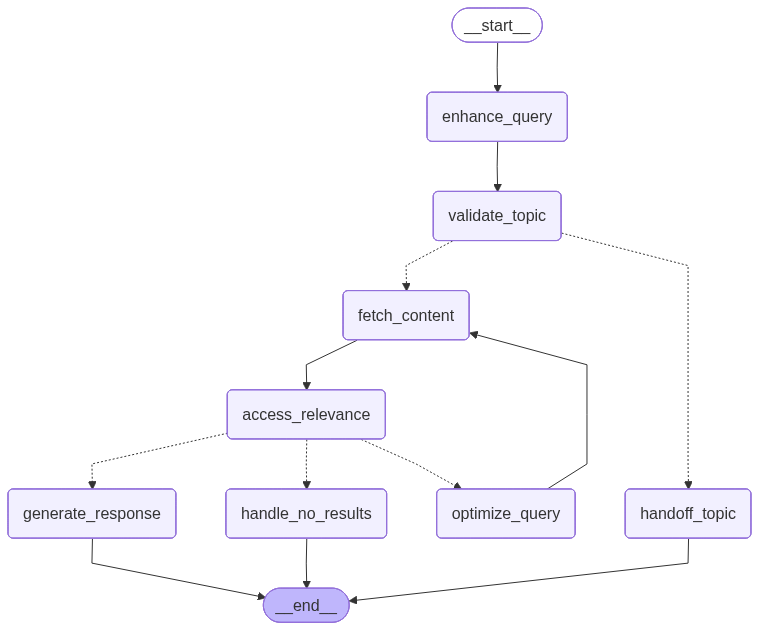

In [283]:
workflow

In [284]:
print("🧪 Testing Advanced RAG Agent\n")

# Test 1: Off-topic query
print("=== Test 1: Off-Topic Query ===")
test_input = {"current_query": HumanMessage(content="What's the weather like today?")}
result = workflow.invoke(
    input=test_input, 
    config={"configurable": {"thread_id": "test_session_1"}}
)
print(f"Response: {result['conversation_history'][-1].content}\n")

🧪 Testing Advanced RAG Agent

=== Test 1: Off-Topic Query ===
Enhancing query: What's the weather like today?
First query - using original: What's the weather like today?
Validating topic relevance...
Topic classification: Irrelevant (Confidence: High)
Routing based on topic relevance...
   → Routing to off-topic handler
Handling off-topic query...
Response: I'm specialized in helping with TechFlow Solutions services, pricing, and company information. 
    Your question seems to be outside my area of expertise. 

    I can help you with:
    - Our cloud infrastructure services and pricing
    - Support procedures and response times  
    - Company information and team details
    - Security and compliance features

    Is there something specific about TechFlow Solutions I can help you with?



In [285]:
# Test 2: On-topic query about pricing
print("=== Test 2: Service Pricing Query ===")
test_input = {"current_query": HumanMessage(content="What are your support service pricing options?")}
result = workflow.invoke(
    input=test_input,
    config={"configurable": {"thread_id": "test_session_2"}}
)
print(f"Response: {result['conversation_history'][-1].content}\n")

=== Test 2: Service Pricing Query ===
Enhancing query: What are your support service pricing options?
First query - using original: What are your support service pricing options?
Validating topic relevance...
Topic classification: Relevant (Confidence: High)
Routing based on topic relevance...
   → Proceeding to content retrieval
Fetching relevant documents...
Document1:TechFlow Solutions offers three main service tiers
Document2:TechFlow Solutions offers three main service tiers
Assessing document relevance...
Document 2: Relevant_Document - The document directly lists the pricing options for support services, including different tiers and their associated monthly costs.
Document 2: Relevant_Document - The document directly lists the pricing options for support services offered by TechFlow Solutions, including different tiers and their respective costs.
Routing based on document quality...
   → Optimizing query for better results
Optimized query (attempt 1): support plan costs
Fetchin